In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
ticker = "^GSPC"
start_date = "2018-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate log returns of adjusted close price
sp500_data['Log_Return'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1))
sp500_data.dropna(inplace=True)
sp500_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log_Return
Date,,,,,,,
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000,0.006378
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000,0.004021
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000,0.007009
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000,0.001661
2018-01-09,2751.149902,2759.139893,2747.860107,2751.290039,2751.290039,3467460000,0.001302
...,...,...,...,...,...,...,...
2023-07-20,4554.379883,4564.740234,4527.560059,4534.870117,4534.870117,3761770000,-0.006780
2023-07-21,4550.160156,4555.000000,4535.790039,4536.339844,4536.339844,3570190000,0.000324
2023-07-24,4543.390137,4563.410156,4541.290039,4554.640137,4554.640137,3856250000,0.004026


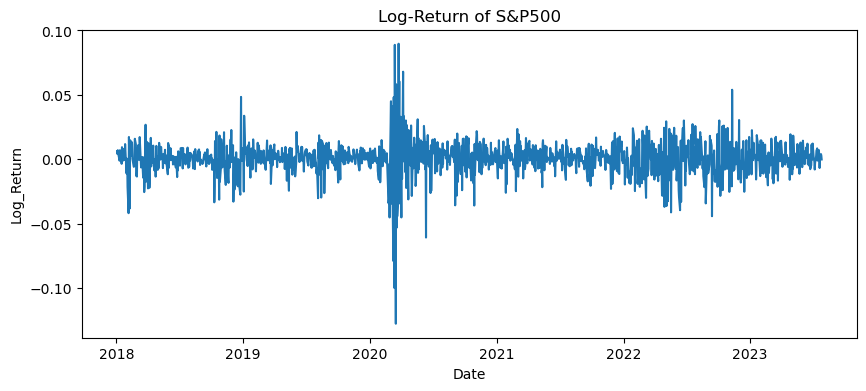

In [4]:
log_return = sp500_data['Log_Return']
plt.figure(figsize=(10,4))
plt.plot(log_return)
plt.xlabel('Date')
plt.ylabel('Log_Return')
plt.title('Log-Return of S&P500')
plt.show()

### ARIMA Fit of S&P500 Log_Returns

final ARIMA order chosen: (4, 0, 5)


<Figure size 1000x400 with 0 Axes>

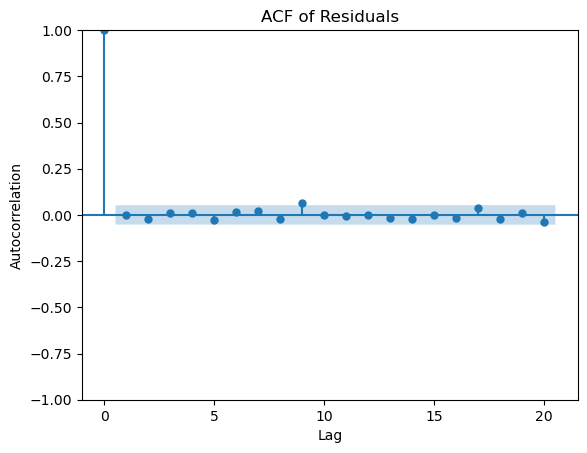

<Figure size 1000x400 with 0 Axes>

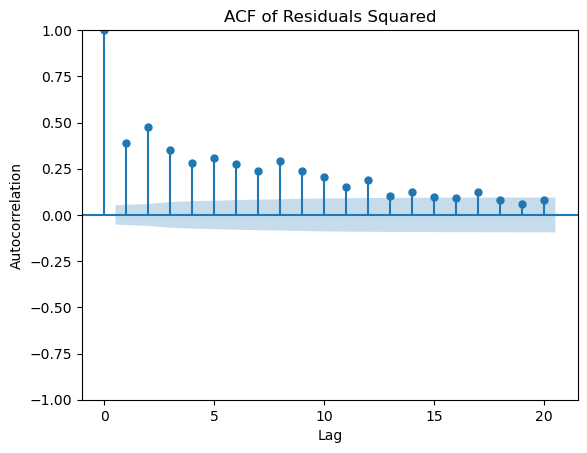

In [5]:
warnings.filterwarnings("ignore")
final_aic = float('inf')
final_order = (0,0,0)
for p in range(6):
    for d in range(3):
        for q in range(6):
            if p==0 and q==0:
                continue
            try:
                # Fit ARIMA model
                model_fit = ARIMA(log_return, order=(p,d,q)).fit()
            except:
                continue

            current_aic = model_fit.aic
            if current_aic<final_aic:
                final_aic = current_aic
                final_order = (p,d,q)
                final_arima = model_fit

print(f'final ARIMA order chosen: {final_order}')
residuals = final_arima.resid
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=20, alpha=0.05)
plt.title(f'ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

residual2 = np.square(residuals)
plt.figure(figsize=(10, 4))
plot_acf(residual2, lags=20, alpha=0.05)
plt.title(f'ACF of Residuals Squared')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()                

#### LJUNG-BOX Test To check if the residuals are white noise or not

In [6]:
box_test_result  = acorr_ljungbox(residuals,lags=20,return_df=True)
print(box_test_result[-3:])
if box_test_result.iloc[-1]['lb_pvalue']>0.05:
    print('Residuals are white noise with 95% confidence')

      lb_stat  lb_pvalue
18  13.455366   0.763843
19  13.691884   0.801347
20  15.913235   0.721992
Residuals are white noise with 95% confidence


#### ARIMA Prediction(In-Sample) on different time horizons

In [7]:
start = '2019-02-01'
end = '2019-07-30'
arima_prediction = final_arima.predict(start=start,end=end)
print(arima_prediction)

Date
2019-02-01    0.002592
2019-02-04   -0.001237
2019-02-05    0.001166
2019-02-06   -0.001582
2019-02-07    0.001686
                ...   
2019-07-24   -0.000563
2019-07-25    0.001523
2019-07-26    0.000250
2019-07-29   -0.000211
2019-07-30   -0.000286
Name: predicted_mean, Length: 124, dtype: float64


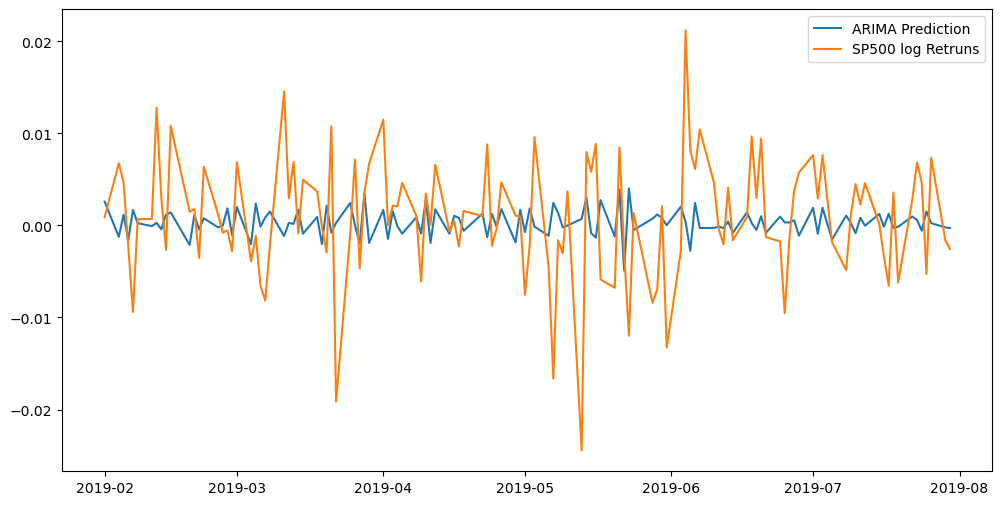

In [8]:
data = log_return.loc['2019-02-01':'2019-07-30']
plt.figure(figsize=(12,6))
plt.plot(arima_prediction,label='ARIMA Prediction')
plt.plot(data,label='SP500 log Retruns')
plt.legend()
plt.show()

### FIT TGARCH on Residuals of ARIMA model
It will allow us to capture the volatility and improve our model

#### TGARCH with 'Constant' Mean Model
Standard Normal to model White Noise

In [16]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0,0)
    for p_garch in range(5):
        for q_garch in range(5):
            
            if p==0 and q==0:
                continue
            try:
                vol_model = arch_model(train,mean='Constant',vol='GARCH',p=p_garch,o=1,q=q_garch).fit(disp='off',show_warning=False)
            except:
                continue    
            if vol_model.aic<vol_aic:
                vol_aic = vol_model.aic
                final_vol_model = vol_model
                vol_order = (p_garch,1,q_garch)

    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.standard_normal()+f.mean['h.1'].iloc[-1])  
print('Chosen TGARCH order: ',vol_order)

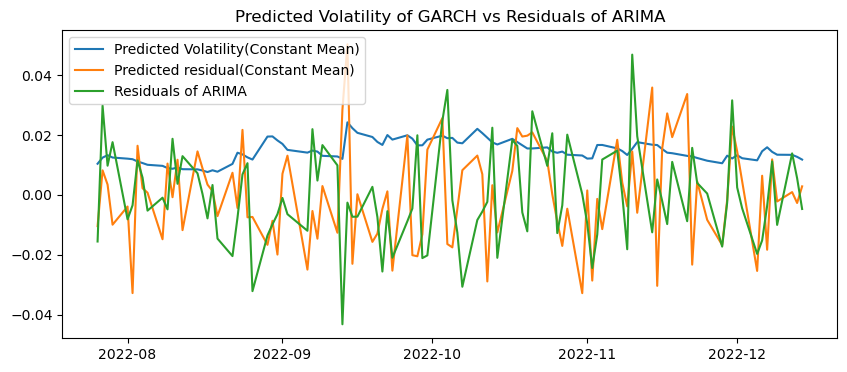

In [17]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(Constant Mean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(Constant Mean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Constant' mean model is 0.01671519828576086


<Figure size 1000x400 with 0 Axes>

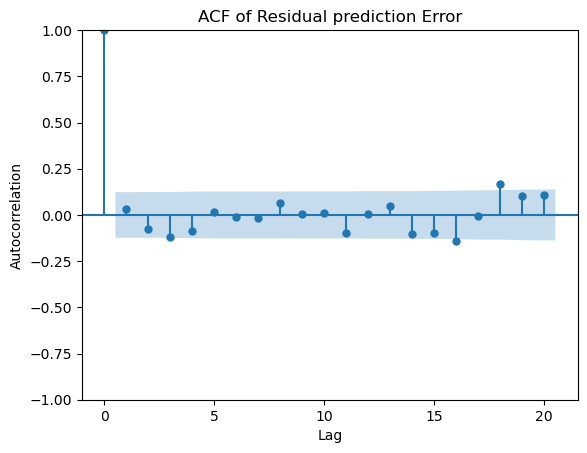

<Figure size 1000x400 with 0 Axes>

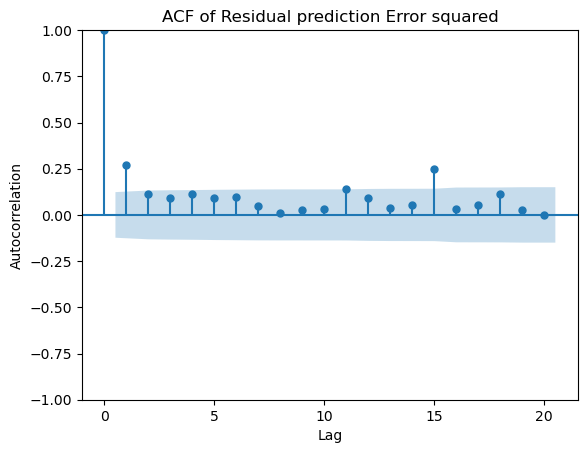

In [18]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Constant' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error squared')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

#### TGARCH with Zero mean model 
(Standard Normal to model white Noise)

In [5]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0)
    for p_garch in range(6):
        for o in range(1,3):
            for q_garch in range(6):
                if p==0 and q==0:
                    continue
                try:
                    vol_model = arch_model(train,mean='Zero',vol='GARCH',p=p_garch,o=o,q=q_garch).fit(disp='off',show_warning=False)
                except:
                    continue    
                if vol_model.aic<vol_aic:
                    vol_aic = vol_model.aic
                    final_vol_model = vol_model
                    vol_order = (p_garch,1,q_garch)
    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.standard_normal())    
print('Chosen TGARCH order: ',vol_order)     

Chosen TGARCH order:  (1, 1, 1)


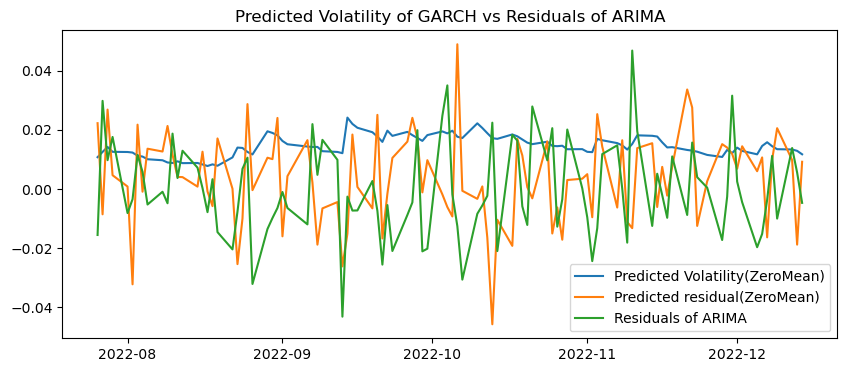

In [6]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(ZeroMean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(ZeroMean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Zero' mean model is 0.017560460879672495


<Figure size 1000x400 with 0 Axes>

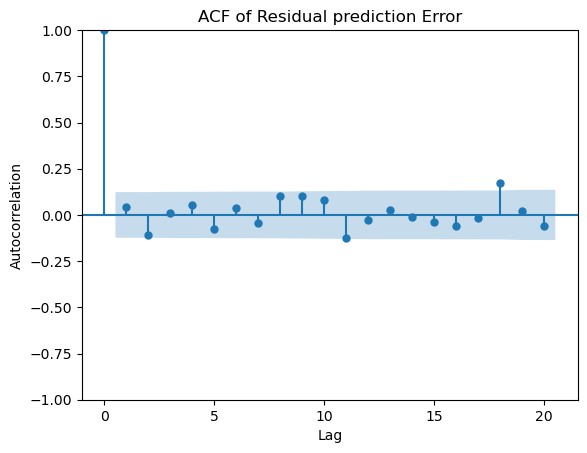

<Figure size 1000x400 with 0 Axes>

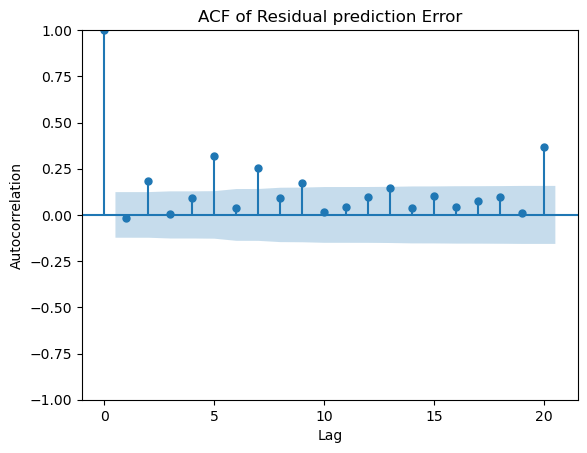

In [7]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Zero' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [8]:
box_test_result  = acorr_ljungbox(residual_prediction_error,lags=20,return_df=True)
print(box_test_result[-3:])
if box_test_result.iloc[-1]['lb_pvalue']>0.05:
    print('Residual prediction errors are white noise with 95% confidence')
else:
    print('residuals are not white noise')    

      lb_stat  lb_pvalue
18  27.847740   0.064410
19  27.966872   0.084068
20  28.934855   0.089050
Residual prediction errors are white noise with 95% confidence


#### TGARCH Fit with Laplace Distribution used as modelling white noise

In [14]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0)
    for p_garch in range(6):
        for o in range(1,3):
            for q_garch in range(6):
                if p==0 and q==0:
                    continue
                try:
                    vol_model = arch_model(train,mean='Zero',vol='GARCH',p=p_garch,o=o,q=q_garch).fit(disp='off',show_warning=False)
                except:
                    continue    
                if vol_model.aic<vol_aic:
                    vol_aic = vol_model.aic
                    final_vol_model = vol_model
                    vol_order = (p_garch,1,q_garch)    
    #parameters for laplace distribution:
    loc = 0
    scale = np.sqrt(0.5)
    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.laplace(loc=loc,scale=scale))    
print('Chosen TGARCH order: ',vol_order)     

Chosen TGARCH order:  (1, 1, 1)


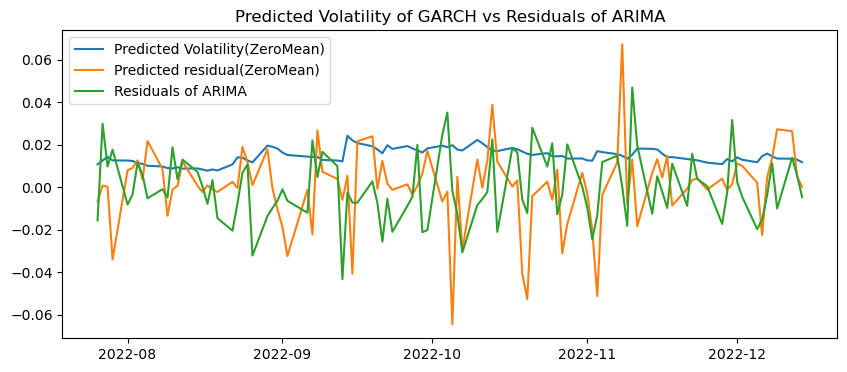

In [19]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(ZeroMean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(ZeroMean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Zero' mean model is 0.01784541607155347


<Figure size 1000x400 with 0 Axes>

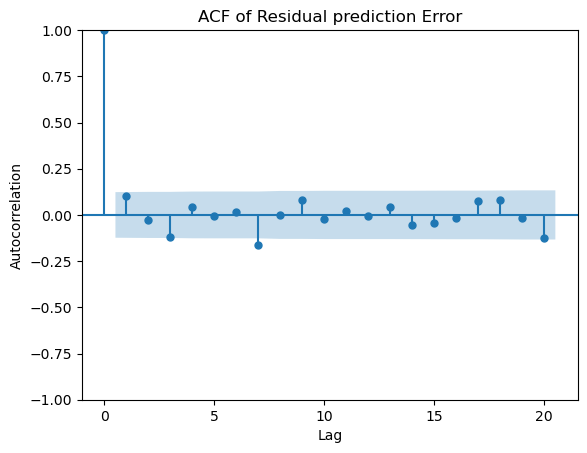

<Figure size 1000x400 with 0 Axes>

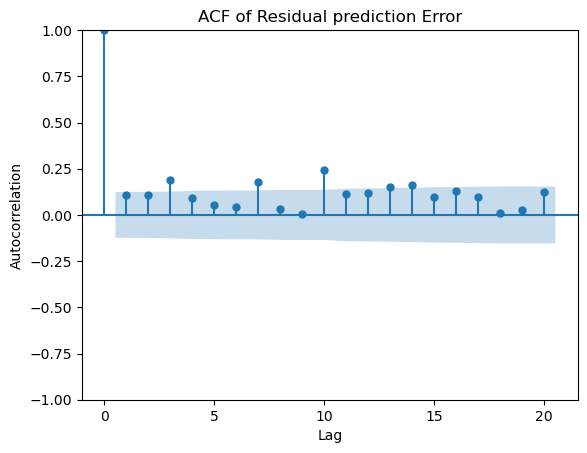

In [20]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Zero' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [21]:
box_test_result  = acorr_ljungbox(residual_prediction_error,lags=20,return_df=True)
print(box_test_result[-3:])
if box_test_result.iloc[-1]['lb_pvalue']>0.05:
    print('Residual prediction errors are white noise with 95% confidence')
else:
    print('residuals are not white noise')    

      lb_stat  lb_pvalue
18  21.011012   0.278858
19  21.087066   0.332010
20  25.261158   0.191622
Residual prediction errors are white noise with 95% confidence


In [12]:
vol_forecast = []
residual_forecast = []
test = 252
for i in range(test):
    train = residuals.iloc[i:-test+i]
    #AIC based model selection
    vol_aic = float('inf')
    vol_order = (0,0,0)
    for p_garch in range(5):
        for q_garch in range(5):
            
            if p==0 and q==0:
                continue
            try:
                vol_model = arch_model(train,mean='Constant',vol='GARCH',p=p_garch,o=1,q=q_garch).fit(disp='off',show_warning=False)
            except:
                continue    
            if vol_model.aic<vol_aic:
                vol_aic = vol_model.aic
                final_vol_model = vol_model
                vol_order = (p_garch,1,q_garch)
    #Parameters for Laplace Distribution:
    loc = 0
    scale = np.sqrt(0.5)
    f = final_vol_model.forecast(horizon=1)
    vol_forecast.append(np.sqrt(f.variance['h.1'].iloc[-1]))
    residual_forecast.append(vol_forecast[i]*np.random.laplace(loc=loc,scale=scale)+f.mean['h.1'].iloc[-1])  
print('Chosen TGARCH order: ',vol_order)

Chosen TGARCH order:  (1, 1, 1)


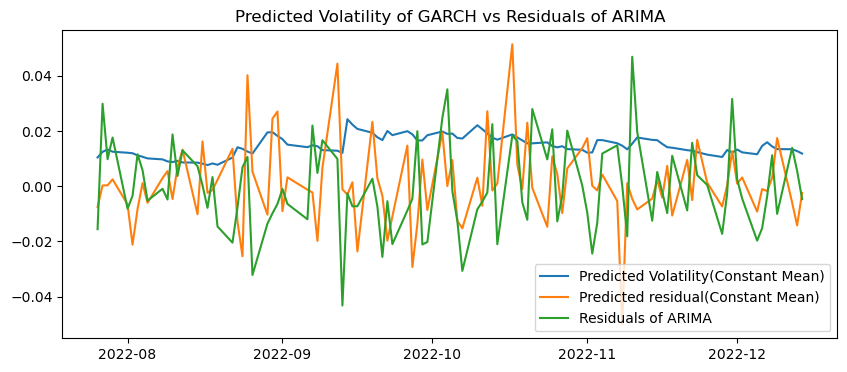

In [15]:
vol_forecast_series = pd.Series(vol_forecast,index=residuals.index[-test:])
residual_forecast_series = pd.Series(residual_forecast,index= residuals.index[-test:])
plt.figure(figsize=(10,4))
plt.plot(vol_forecast_series[:100],label='Predicted Volatility(Constant Mean)')
plt.plot(residual_forecast_series[:100],label='Predicted residual(Constant Mean)')
plt.plot(residuals.iloc[-test:-test+100],label='Residuals of ARIMA')
plt.legend()
plt.title('Predicted Volatility of GARCH vs Residuals of ARIMA')
plt.show()

RMSE of GARCH with 'Constant' mean model is 0.016386669581295976


<Figure size 1000x400 with 0 Axes>

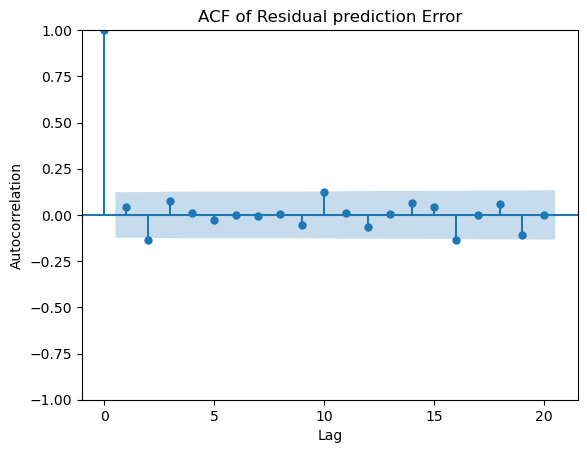

<Figure size 1000x400 with 0 Axes>

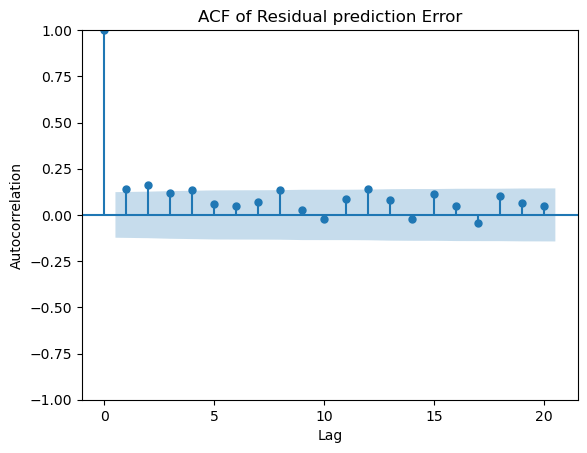

In [14]:
residual_prediction_error = residual_forecast_series - residuals.iloc[-test:]
rmse = np.sqrt(np.square(residual_prediction_error).mean())
print(f"RMSE of GARCH with 'Constant' mean model is {rmse}")
plt.figure(figsize=(10, 4))
plot_acf(residual_prediction_error, lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(np.square(residual_prediction_error), lags=20, alpha=0.05)
plt.title(f'ACF of Residual prediction Error')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [11]:
box_test_result  = acorr_ljungbox(residual_prediction_error,lags=20,return_df=True)
print(box_test_result[-3:])
if box_test_result.iloc[-1]['lb_pvalue']>0.05:
    print('Residual prediction errors are white noise with 95% confidence')
else:
    print('residuals are not white noise')    

      lb_stat  lb_pvalue
18  39.576675   0.002383
19  39.686666   0.003597
20  41.264796   0.003444
residuals are not white noise


### Observations:
#### 1) TGARCH does better in describing correlation of variance when compared to GARCH which is evident from ACFs
#### 2) Significant improvement of RMSE in the same range was not observed in TGARCH when compared with GARCH
#### 3) Consistency of predictions depends to some extent on random white noise modelling in the algorithm, although performance differed marginally
#### 4) Laplace distribution modelling of white noise seemed to perform more consistently than standard normal model when performed the experiment several times. Although evidence is insufficient to reach any conclusion 